**1)** Consider a dense neural network classifier with 2D input, 1 hidden layer with 3 neurons with ReLU activation, and 3D output with softmax. Generate random numbers for the weights and compute the output for (4,5). Then, compute the gradient with respect to the weights using backpropagation for a MSE loss. (Paper and pencil question)

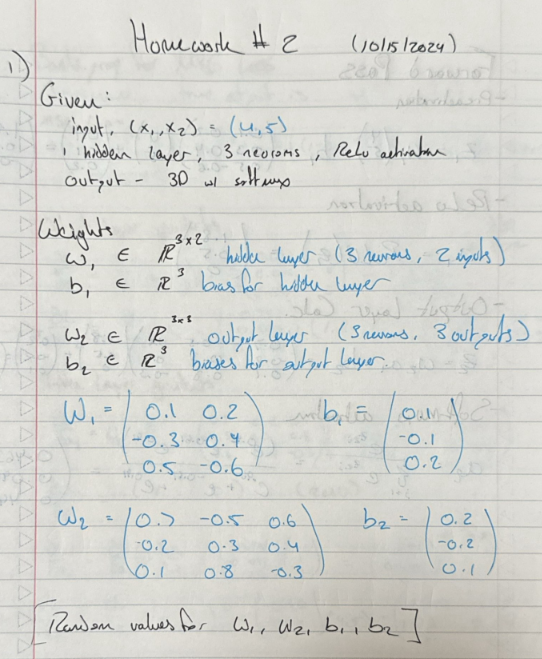
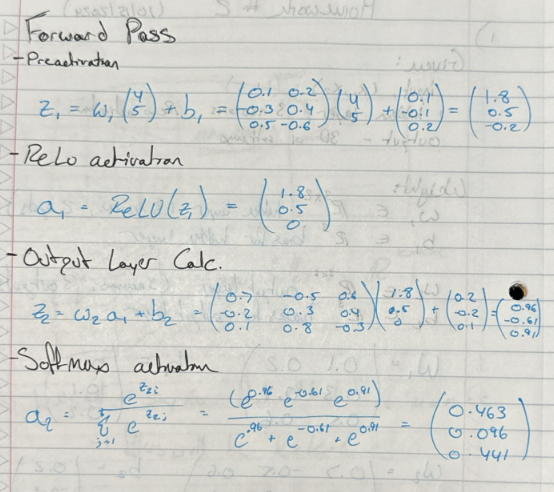
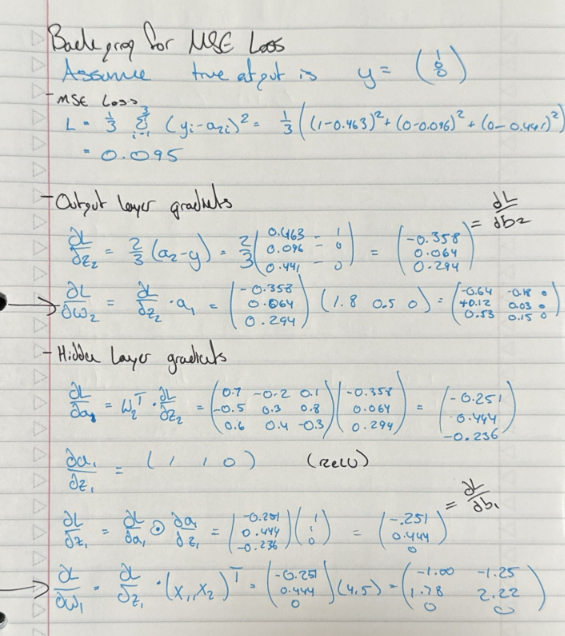

**2)** Use a feedforward NN to classify the CIFAR-10 dataset, and tune its hyperparameters as best you can. You must use PyTorch. Requirements below.

Randomly split the dataset into 60%/20/%/20% training/validation/testing sets. When tuning hyperparameters, test on the validation set. After you find the best hyperparameters, run your code once with these settings on the test. Use random_state = 1 before splitting data.

Start with a single 10-node hidden layer as a benchmark.

You must run at least one experiment using all major techniques:

*   Normalization/Standardization
*   Weight Initialization
*   Activation functions
*   Loss functions
*   Regularization (must include dropout)


For each experiment, document why you chose to run this experiment, training accuracy/loss, validation accuracy/loss, epoch number with best validation accuracy (use early stopping), and training runtime.

Training takes significant time, so brute force is not feasible. Make informed decisions on how to proceed and write your reasoning in your report. Include all fruitful experiments you run along the way. More importantly than the results, I want to see that you are thinking well and making good decisions. Good results will come from eventually if you understand what you are doing.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchsummary import summary
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
import time

In [2]:
# CIFAR-10 dataset preprocessing
transform = transforms.Compose([
    transforms.ToTensor()
])
# # CIFAR-10 dataset preprocessing with data augmentation
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
#     transforms.RandomCrop(32, padding=4),  # Randomly crop the image with padding
#     transforms.ToTensor()  # Convert the image to a tensor
# ])
# Load CIFAR-10 dataset
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split dataset into 60/20/20
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Random Seed = 1
random_seed = 1
torch.manual_seed(random_seed)  # Controls randomness in PyTorch, including weight initialization
torch.cuda.manual_seed(random_seed)  # If using CUDA

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)  # Increase batch size
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 84.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# Define the LeNetReg model with Dropout and regularization
class LeNetReg(nn.Module):
    def __init__(self, height, width, depth, classes, dropout=[0, 0, 0, 0.25]):
        super(LeNetReg, self).__init__()

        # Sequential model for layers
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=depth, out_channels=32, kernel_size=(5, 5), padding='same'),
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(dropout[0]),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding='same'),
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(dropout[1]),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), padding='same'),
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout[2]),

            # # New convolutional layer with a smaller kernel size
            # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding='same'),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  # Optional: Add pooling if needed
            # nn.Dropout(dropout[3]),

            nn.Flatten(),
            nn.Linear(in_features=(128 * 8 * 8), out_features=250),  # Adjust for the size after pooling
            # nn.Linear(in_features=(256 * 4 * 4), out_features=500),  # Adjust for the size after pooling
            nn.ReLU(),
            nn.Dropout(dropout[3]),

            nn.Linear(250, classes),

            # nn.Flatten(),
            # nn.Linear(in_features=(3 * 32 * 32), out_features=10),  # Adjust for the size after pooling
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

# Function to initialize weights with He (Kaiming) initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        # He initialization (recommended for ReLU)
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNetReg(height=32, width=32, depth=3, classes=10).to(device)
model.apply(init_weights) # Weight initialization

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
# Lowered learning rate and L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# Schedule LR drop if accuracy plateus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Train function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss with CrossEntropyLoss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total
    print(f'Train Epoch: {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy

# Validation function
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Calculate loss
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    avg_loss = val_loss / len(val_loader)
    accuracy = correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy

# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Calculate loss
            loss = criterion(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy


summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
           Dropout-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          51,264
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              ReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
          Dropout-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]         204,928
      BatchNorm2d-12            [-1, 128, 8, 8]             256
             ReLU-13            [-1, 128, 8, 8]               0
          Dropout-14            [-1, 12

In [4]:
# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
best_val_accuracy = 0.0
best_epoch = 0
patience_counter = 0

# Track total runtime
start_time = time.time()

# Training and validation loop
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):

    start = time.time()

    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    val_loss, val_accuracy = validate(model, device, val_loader)

    scheduler.step(val_loss)  # Adjust the learning rate based on validation loss

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check if validation accuracy has improved
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch  # +1 because epoch starts from 0
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1

    # Stop if no improvement for patience epochs
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation accuracy.')
        num_epochs = epoch
        break

    # Print epoch runtime
    finish = time.time()
    epoch_runtime = finish - start
    print(f'Epoch Runtime: {epoch_runtime:.2f} seconds\n')

# Test the model on the test set
test_loss, test_accuracy = test(model, device, test_loader)

# Total runtime
total_runtime = time.time() - start_time

# Final results printout
print("\n--- Experiment Summary ---")
print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
print(f"Total Training Runtime: {total_runtime:.2f} seconds")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at Epoch {best_epoch} of {num_epochs}")
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.4f}")


Train Epoch: 0, Loss: 2.0905, Accuracy: 0.3693
Validation Loss: 2.0116, Accuracy: 0.4505
Epoch Runtime: 6.63 seconds

Train Epoch: 1, Loss: 1.9758, Accuracy: 0.4879
Validation Loss: 1.9449, Accuracy: 0.5201
Epoch Runtime: 5.88 seconds

Train Epoch: 2, Loss: 1.9214, Accuracy: 0.5453
Validation Loss: 1.9165, Accuracy: 0.5462
Epoch Runtime: 5.93 seconds

Train Epoch: 3, Loss: 1.8802, Accuracy: 0.5901
Validation Loss: 1.8936, Accuracy: 0.5715
Epoch Runtime: 5.93 seconds

Train Epoch: 4, Loss: 1.8452, Accuracy: 0.6274
Validation Loss: 1.8690, Accuracy: 0.5968
Epoch Runtime: 5.99 seconds

Train Epoch: 5, Loss: 1.8152, Accuracy: 0.6579
Validation Loss: 1.8543, Accuracy: 0.6139
Epoch Runtime: 5.99 seconds

Train Epoch: 6, Loss: 1.7904, Accuracy: 0.6828
Validation Loss: 1.8403, Accuracy: 0.6256
Epoch Runtime: 5.94 seconds

Train Epoch: 7, Loss: 1.7696, Accuracy: 0.7074
Validation Loss: 1.8295, Accuracy: 0.6374
Epoch Runtime: 5.89 seconds

Train Epoch: 8, Loss: 1.7510, Accuracy: 0.7276
Validatio

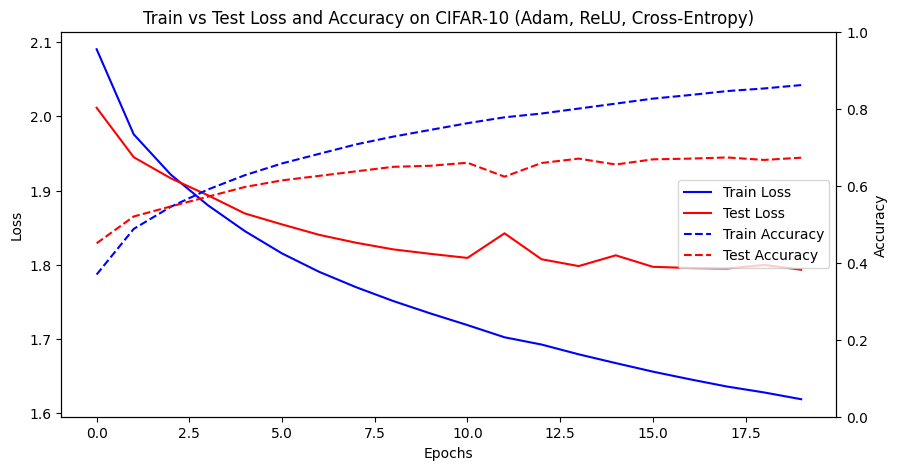

In [5]:
# Plot Train Loss vs Test Loss and Train Accuracy vs Test Accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting Train and Test Loss on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')

train_loss_line, = ax1.plot(train_losses, label='Train Loss', color='blue')
val_loss_line, = ax1.plot(val_losses, label='Test Loss', color='red')

ax1.tick_params(axis='y')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='black')

ax2.set_ylim(0.0, 1.0)  # Set the right axis for accuracy from 0 to 1

train_acc_line, = ax2.plot(train_accuracies, label='Train Accuracy', color='blue', linestyle='--')
val_acc_line, = ax2.plot(val_accuracies, label='Test Accuracy', color='red', linestyle='--')

ax2.tick_params(axis='y')

# Adding legend for both axes
lines = [train_loss_line, val_loss_line, train_acc_line, val_acc_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

# Title for the plot
plt.title('Train vs Test Loss and Accuracy on CIFAR-10 (Adam, ReLU, Cross-Entropy)')
plt.show()


Experiment 1:

Foundation taken from class notes (week 6). Major changes: random_state set to 1, network shrunk down to a single 10-node hidden layer, early stopping added:

--- Experiment Summary ---

Training Loss: 2.1131, Training Accuracy: 0.3462

Validation Loss: 2.1268, Validation Accuracy: 0.3295

Total Training Runtime: 118.52 seconds

Best Validation Accuracy: 0.3327 at Epoch 16 of 20

Final Test Loss: 2.1287, Final Test Accuracy: 0.3291

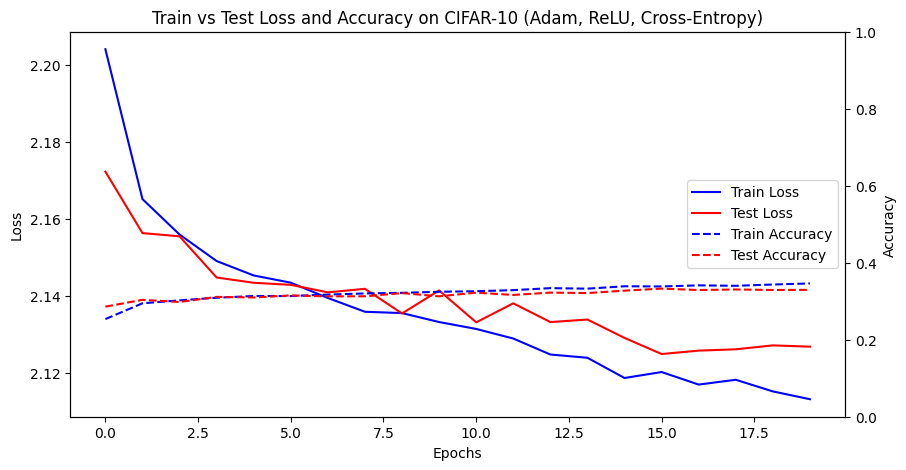

Experiment 2:

Three convolutional layers added into the NN with ReLU activation, Max pooling added after first two convolutions. Idea inspired from in-class example. Convolutions will help extract local features and the max pooling will further identify features and shrink the number of parameters.

--- Experiment Summary ---

Training Loss: 1.9702, Training Accuracy: 0.5036

Validation Loss: 2.0562, Validation Accuracy: 0.4089

Total Training Runtime: 176.19 seconds

Best Validation Accuracy: 0.4175 at Epoch 19 of 20

Final Test Loss: 2.0367, Final Test Accuracy: 0.4327

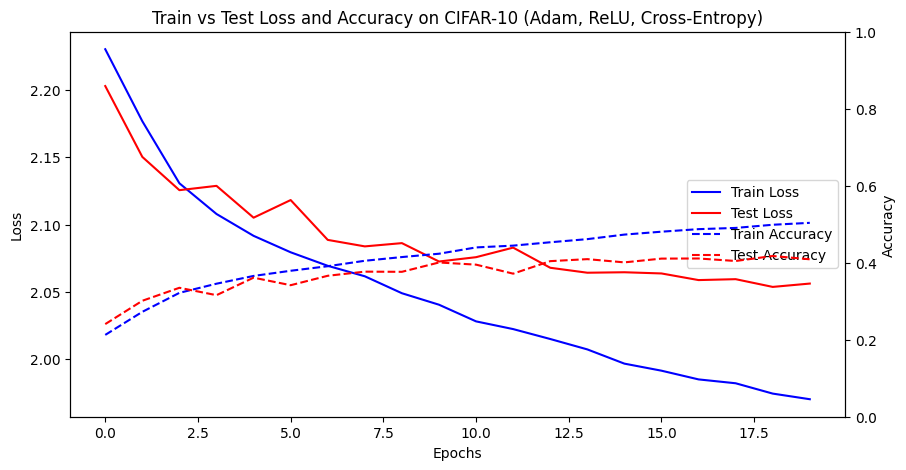


Experiment 3:

Added in dropout to each convolutional layer (10%) and the first dense layer (50%). Did not work well, early stopping canceled the training almost immediately.

--- Experiment Summary ---

Training Loss: 2.3026, Training Accuracy: 0.1023

Validation Loss: 2.3027, Validation Accuracy: 0.
0946

Total Training Runtime: 52.22 seconds

Best Validation Accuracy: 0.1609 at Epoch 1 of 5

Final Test Loss: 2.3033, Final Test Accuracy: 0.0986

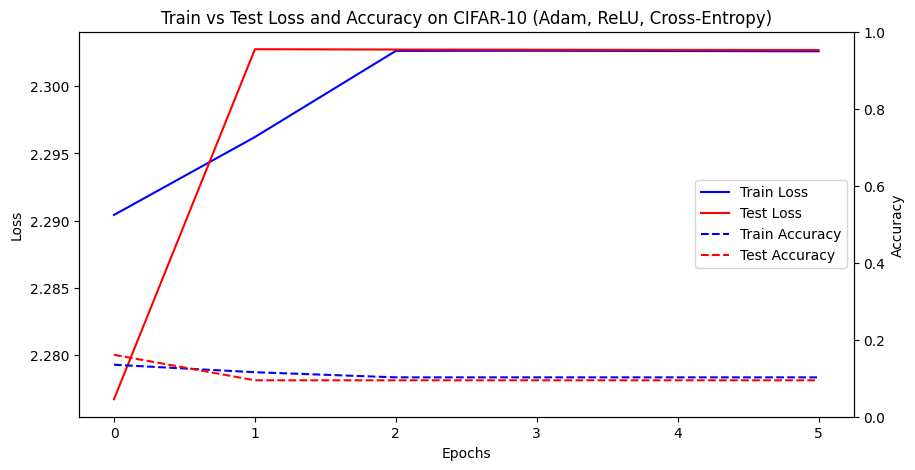

Experiment 4:

Removed dropout from the convolutional layers and expanded the dense layer. Rather than 10 nodes, I increased it to 500 nodes.

--- Experiment Summary ---

Training Loss: 1.7347, Training Accuracy: 0.7268

Validation Loss: 1.8131, Validation Accuracy: 0.6474

Total Training Runtime: 175.28 seconds

Best Validation Accuracy: 0.6513 at Epoch 19 of 20

Final Test Loss: 1.8225, Final Test Accuracy: 0.6361

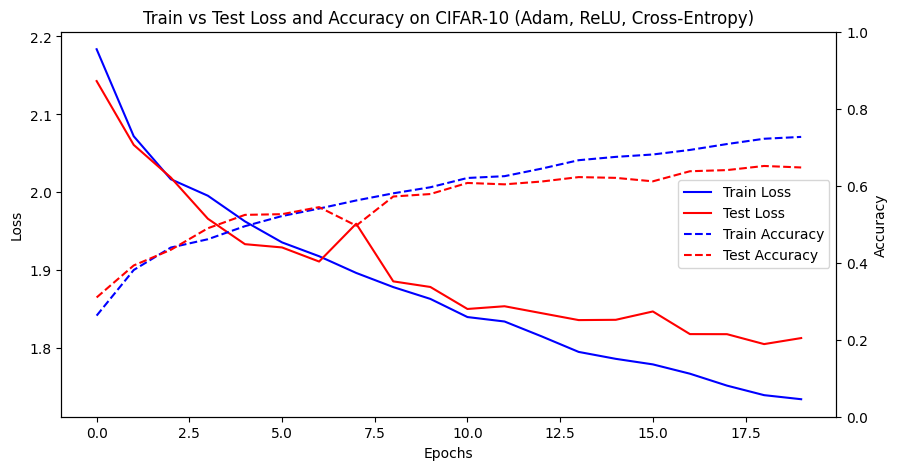

Experiment 5:
Added 5% dropout to the convolutional layers to induce some noise and expanded the dense layer to 1000 nodes. There was effectively no change in the results.

--- Experiment Summary ---

Training Loss: 1.7347, Training Accuracy: 0.7268

Validation Loss: 1.8131, Validation Accuracy: 0.6474

Total Training Runtime: 175.28 seconds

Best Validation Accuracy: 0.6513 at Epoch 19 of 20

Final Test Loss: 1.8225, Final Test Accuracy: 0.6361

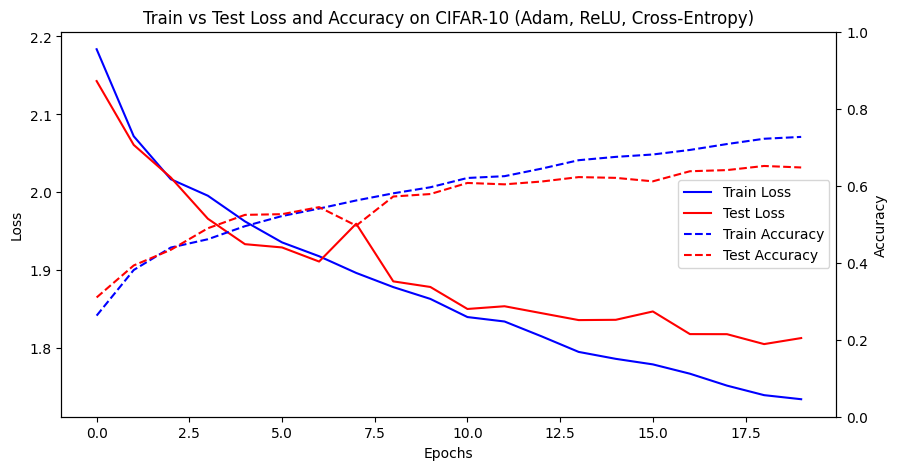

Experiment 6:

I added another convolutional layer at the end with max pooling. I used a kernel size of 3x3 instead of the 5x5 to try to extract finer features. Reduced the dense nodes back to 500 and removed the CNN dropout. No improvement found.

--- Experiment Summary ---

Training Loss: 1.8581, Training Accuracy: 0.6001

Validation Loss: 1.8972, Validation Accuracy: 0.5610

Total Training Runtime: 164.25 seconds

Best Validation Accuracy: 0.5692 at Epoch 13 of
18

Final Test Loss: 1.8964, Final Test Accuracy: 0.5616

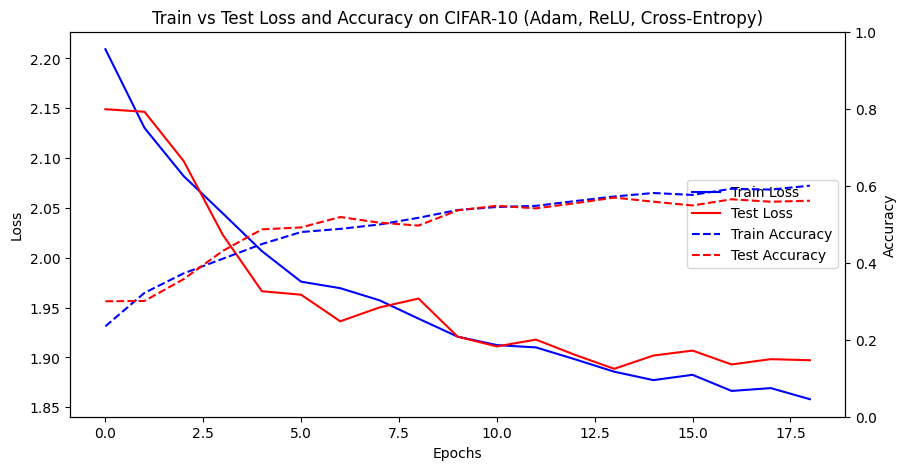

Experiment 7:

Ran two experiments in one. Added in batch normalization to the three convolutional layers (removed the added one) and saw a worsening in the results (accuracy ~54%). As a result I applied the batch normalization only to the second CNN and saw a slight worsening overall but improvement compared to the experiment 6.

--- Experiment Summary ---

Training Loss: 1.8309, Training Accuracy: 0.6287

Validation Loss: 1.8797, Validation Accuracy: 0.5779

Total Training Runtime: 167.42 seconds

Best Validation Accuracy: 0.5993 at Epoch 18 of 20

Final Test Loss: 1.8844, Final Test Accuracy: 0.5768

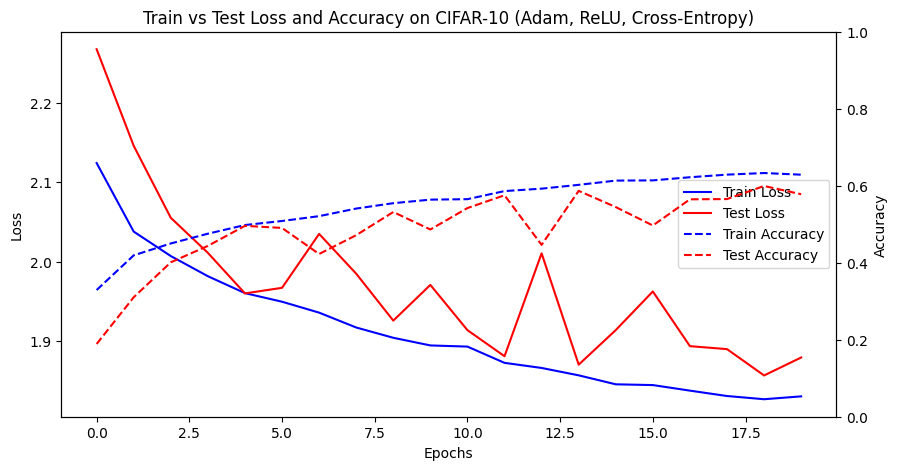

Experiment 8:

Removed the changes from Experiments 5, 6, & 7 to get back to the best results from before. Added weight initialization, specifically He initialization since I am using ReLU activations. Accuracy increased.

--- Experiment Summary ---

Training Loss: 1.6515, Training Accuracy: 0.8100

Validation Loss: 1.7753, Validation Accuracy: 0.
6820

Total Training Runtime: 166.93 seconds

Best Validation Accuracy: 0.6820 at Epoch 19 of 20

Final Test Loss: 1.7827, Final Test Accuracy: 0.6775

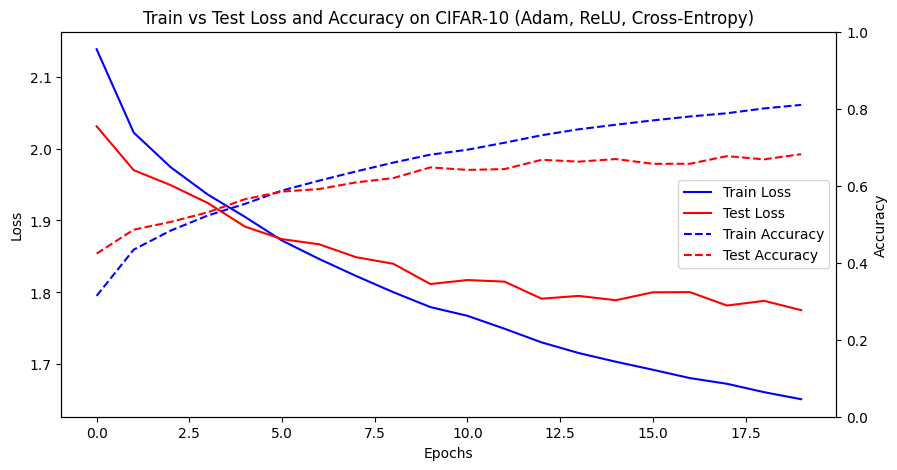

Experiment 9:

Looked deeper into the batch normalization and saw that increasing the batch size, lowering the learning rate, and removing the dropout may improve the results. Saw almost no change in the overall accuracy but the network was overfitting and achieving much higher training accuracy.

--- Experiment Summary ---

Training Loss: 1.5669, Training Accuracy: 0.9019

Validation Loss: 1.8034, Validation Accuracy: 0.6624

Total Training Runtime: 166.01 seconds

Best Validation Accuracy: 0.6665 at Epoch 16 of 20

Final Test Loss: 1.8074, Final Test Accuracy: 0.6600

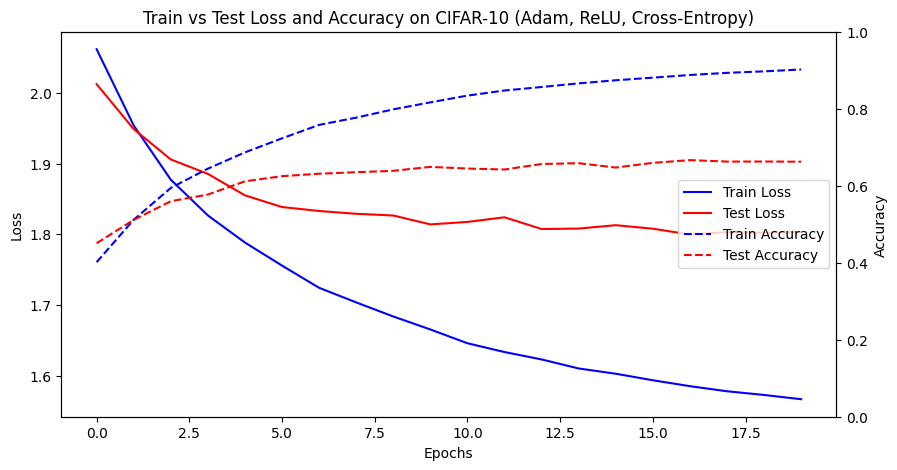

Experiment 10:

Reintroduced dropout but only 25% to the dense layer. I also added in L2 regularization to help control the weights. No significant change in the results.

--- Experiment Summary ---

Training Loss: 1.5923, Training Accuracy: 0.8840

Validation Loss: 1.7943, Validation Accuracy: 0.6725

Total Training Runtime: 169.50 seconds

Best Validation Accuracy: 0.6725 at Epoch 19 of
20

Final Test Loss: 1.8052, Final Test Accuracy: 0.6628

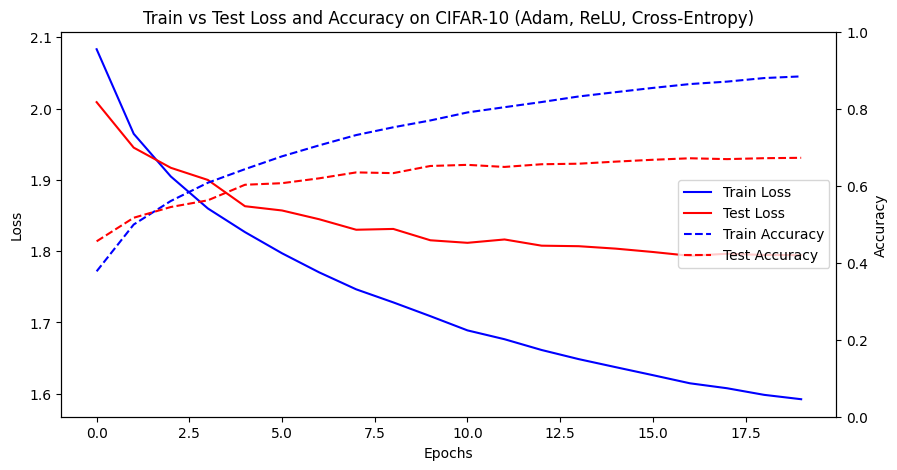

Experiment 11:

Reduced the model complexity to aim at reducing over fitting. Added in a learning rate scheduler to drop the LR if the validation accuracy stalled for more than 3 epochs. Second best results so far, best results were observed in experiment 8 with the addition of the weight initializer.

--- Experiment Summary ---

Training Loss: 1.6178, Training Accuracy: 0.8621

Validation Loss: 1.7906, Validation Accuracy: 0.6779

Total Training Runtime: 166.33 seconds

Best Validation Accuracy: 0.6779 at Epoch 19 of 20

Final Test Loss: 1.7981, Final Test Accuracy: 0.6699

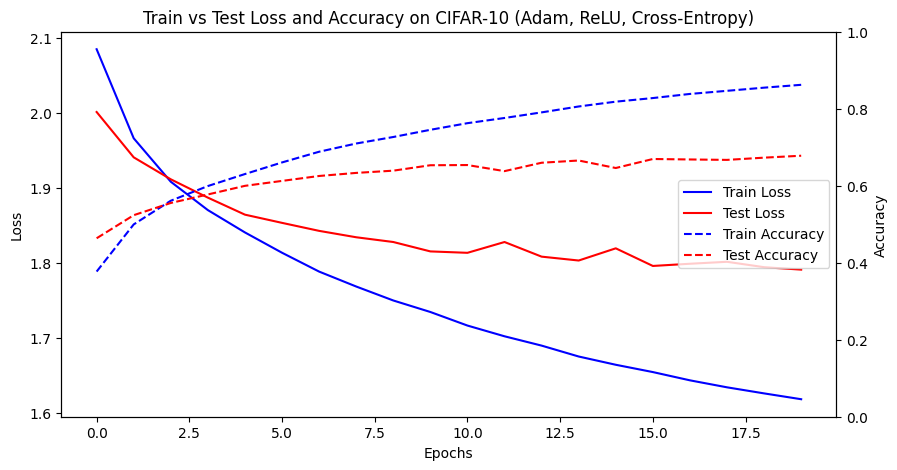

**3)** Repeat problem 2 using a CNN and the Imagenette dataset. Run at least 10 training experiments, but you are free to use any techniques you choose, but much of the credit is based on your reasoning: your progression requires rationale for why you're tuning the hyperparmeterse you choose to tune. Required: Experiment with data augmentation. [GPU computing is recommended for this.]

In [25]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from fastai.data.external import untar_data, URLs
from torchvision.datasets import ImageFolder
import os

# ImageNette dataset preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensor
])

# Download ImageNette dataset using fastai's untar_data
data_dir = untar_data(URLs.IMAGENETTE)

# Load ImageNette dataset
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

# Split train_dataset into train/val sets (if desired)
train_size = int(0.6 * len(train_dataset))
val_size = int(0.2 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

# Random Seed = 1
random_seed = 1
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)  # If using CUDA

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

In [26]:
# Create data loaders
batch_size = 256*4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
# Define the LeNetReg model with Dropout and regularization
class LeNetReg(nn.Module):
    def __init__(self, height, width, depth, classes, dropout=[0, 0, 0, 0.2]):
        super(LeNetReg, self).__init__()

        # Sequential model for layers
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=depth, out_channels=32, kernel_size=(5, 5), padding='same'),
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(dropout[0]),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding='same'),
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(dropout[1]),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), padding='same'),
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout[2]),

            # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(5, 5), padding='same'),
            # nn.BatchNorm2d(256),  # Batch Normalization
            # nn.ReLU(),
            # nn.Dropout(dropout[2]),

            nn.Flatten(),
            # Update in_features based on the calculated output shape
            # nn.Linear(in_features=(256 * 56 * 56), out_features=250),  # Updated line
            nn.Linear(in_features=(128 * 56 * 56), out_features=150),  # Updated line

            nn.ReLU(),
            nn.Dropout(dropout[3]),

            nn.Linear(150, classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNetReg(height=224, width=224, depth=3, classes=10).to(device)
model.apply(init_weights)  # Weight initialization

# Check the model summary again
summary(model, input_size=(3, 224, 224))


# Function to initialize weights with He (Kaiming) initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        # He initialization (recommended for ReLU)
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNetReg(height=224, width=224, depth=3, classes=10).to(device)
model.apply(init_weights) # Weight initialization

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
# Lowered learning rate and L2 regularization
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Schedule LR drop if accuracy plateus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Train function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss with CrossEntropyLoss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total
    print(f'Train Epoch: {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy

# Validation function
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Calculate loss
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    avg_loss = val_loss / len(val_loader)
    accuracy = correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy

# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Calculate loss
            loss = criterion(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy


summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           2,432
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
           Dropout-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          51,264
       BatchNorm2d-7         [-1, 64, 112, 112]             128
              ReLU-8         [-1, 64, 112, 112]               0
         MaxPool2d-9           [-1, 64, 56, 56]               0
          Dropout-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]         204,928
      BatchNorm2d-12          [-1, 128, 56, 56]             256
             ReLU-13          [-1, 128, 56, 56]               0
          Dropout-14          [-1, 128,

In [35]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 10        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2680 MiB |  34592 MiB |  39993 GiB |  39990 GiB |
|       from large pool |   2671 MiB |  34585 MiB |  39970 GiB |  39967 GiB |
|       from small pool |      9 MiB |     11 MiB |     22 GiB |     22 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   2680 MiB |  34592 MiB |  39993 GiB |  39990 GiB |
|       from large pool |   2671 MiB |  34585 MiB |  39970 GiB |

In [50]:
# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
best_val_accuracy = 0.0
best_epoch = 0
patience_counter = 0

# Track total runtime
start_time = time.time()

# Training and validation loop
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):

    start = time.time()

    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    val_loss, val_accuracy = validate(model, device, val_loader)

    scheduler.step(val_loss)  # Adjust the learning rate based on validation loss

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check if validation accuracy has improved
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch  # +1 because epoch starts from 0
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1

    # Stop if no improvement for patience epochs
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation accuracy.')
        num_epochs = epoch
        break

    # Print epoch runtime
    finish = time.time()
    epoch_runtime = finish - start
    print(f'Epoch Runtime: {epoch_runtime:.2f} seconds\n')

# Test the model on the test set
test_loss, test_accuracy = test(model, device, test_loader)

# Total runtime
total_runtime = time.time() - start_time

# Final results printout
print("\n--- Experiment Summary ---")
print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
print(f"Total Training Runtime: {total_runtime:.2f} seconds")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at Epoch {best_epoch} of {num_epochs}")
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.4f}")


Train Epoch: 0, Loss: 2.2463, Accuracy: 0.2003
Validation Loss: 2.3056, Accuracy: 0.1495
Epoch Runtime: 42.86 seconds

Train Epoch: 1, Loss: 2.1455, Accuracy: 0.3105
Validation Loss: 2.2057, Accuracy: 0.2499
Epoch Runtime: 42.81 seconds

Train Epoch: 2, Loss: 2.0880, Accuracy: 0.3719
Validation Loss: 2.1273, Accuracy: 0.3281
Epoch Runtime: 42.89 seconds

Train Epoch: 3, Loss: 2.0600, Accuracy: 0.3966
Validation Loss: 2.0834, Accuracy: 0.3745
Epoch Runtime: 42.85 seconds

Train Epoch: 4, Loss: 2.0361, Accuracy: 0.4212
Validation Loss: 2.0418, Accuracy: 0.4179
Epoch Runtime: 42.73 seconds

Train Epoch: 5, Loss: 2.0160, Accuracy: 0.4445
Validation Loss: 2.0160, Accuracy: 0.4437
Epoch Runtime: 42.80 seconds

Train Epoch: 6, Loss: 2.0004, Accuracy: 0.4584
Validation Loss: 2.0031, Accuracy: 0.4585
Epoch Runtime: 42.63 seconds

Train Epoch: 7, Loss: 1.9990, Accuracy: 0.4580
Validation Loss: 2.0077, Accuracy: 0.4522
Epoch Runtime: 42.56 seconds

Train Epoch: 8, Loss: 1.9746, Accuracy: 0.4830
V

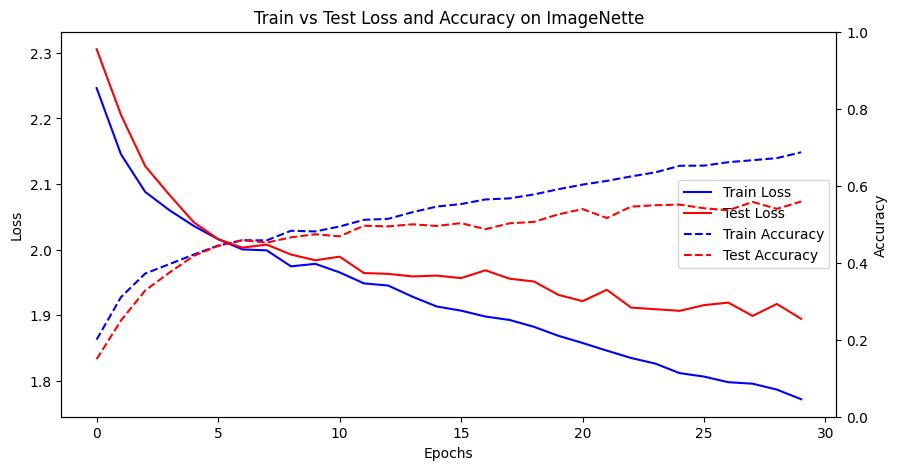

In [51]:
# Plot Train Loss vs Test Loss and Train Accuracy vs Test Accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting Train and Test Loss on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')

train_loss_line, = ax1.plot(train_losses, label='Train Loss', color='blue')
val_loss_line, = ax1.plot(val_losses, label='Test Loss', color='red')

ax1.tick_params(axis='y')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='black')

ax2.set_ylim(0.0, 1.0)  # Set the right axis for accuracy from 0 to 1

train_acc_line, = ax2.plot(train_accuracies, label='Train Accuracy', color='blue', linestyle='--')
val_acc_line, = ax2.plot(val_accuracies, label='Test Accuracy', color='red', linestyle='--')

ax2.tick_params(axis='y')

# Adding legend for both axes
lines = [train_loss_line, val_loss_line, train_acc_line, val_acc_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

# Title for the plot
plt.title('Train vs Test Loss and Accuracy on ImageNette')
plt.show()


Experiment 1:

Adapted CIFAR10 code for imagenette. I initially started with a batch size of 16 but saw an accuracy of ~10% so I bumped it back up to 128 for train/test/val. Overall, extremely poor results with 17% accuracy.

--- Experiment Summary ---

Training Loss: 2.2749, Training Accuracy: 0.1857

Validation Loss: 2.2766, Validation Accuracy: 0.1838

Total Training Runtime: 892.19 seconds

Best Validation Accuracy: 0.1891 at Epoch 8 of 13

Final Test Loss: 2.2893, Final Test Accuracy: 0.1720

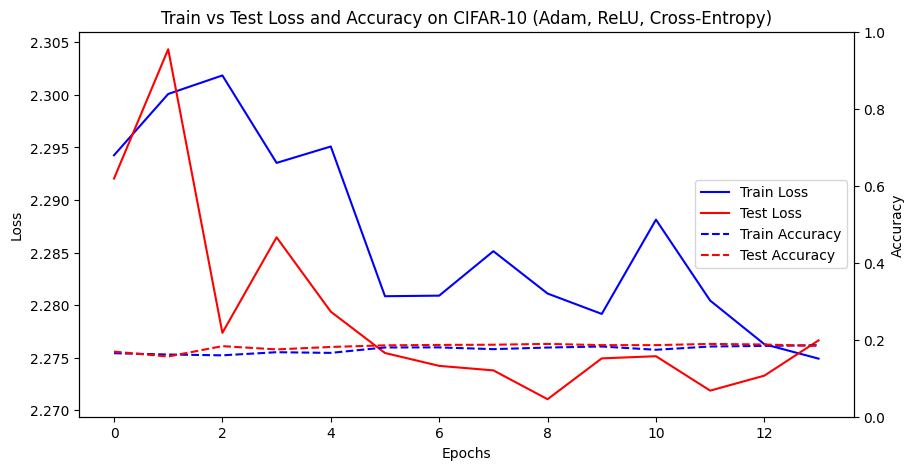



Experiment 2:

I increased the batch size to 256 (from 128), decreased the number of dense nodes to 150 (from 250), and added a convolutional layer at the end. I increased the batch size further to allow a greater training/val bank. I decreased the number of dense nodes to trim down on the training time and added a CNN layer to deepen the network and increase the accuracy. Next I plan on further expanding the CNN layers to further deepen the network while not massively increasing the required compute power.

--- Experiment Summary ---

Training Loss: 2.0418, Training Accuracy: 0.4135

Validation Loss: 2.0568, Validation Accuracy: 0.3978

Total Training Runtime: 1350.06 seconds

Best Validation Accuracy: 0.3978 at Epoch 19 of 20

Final Test Loss: 2.0801, Final Test Accuracy: 0.3842

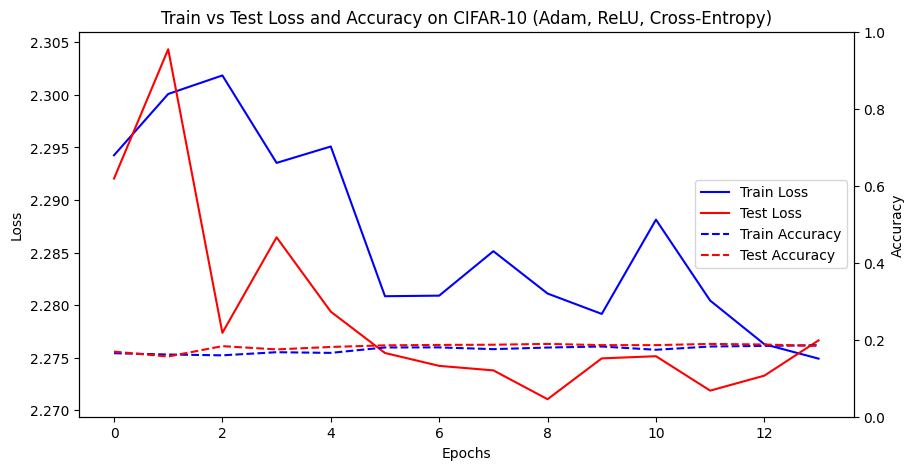

I made an error saving the exp 2 graph, the graph above is from experiment 1

Experiment 3:

I deepended the convolutional portion of the network, I increased the 3 convolutions with max pooling to 9 (3 for each pooling /flattening event). I also decreased the dense nodes to 100 (from 150)

Overall, there was not a drastic change in the final accuracy but I did notice some underfitting early on while training.

--- Experiment Summary ---

Training Loss: 2.0709, Training Accuracy: 0.3908

Validation Loss: 2.0864, Validation Accuracy: 0.3698

Total Training Runtime: 944.32 seconds

Best Validation Accuracy: 0.4057 at Epoch 12 of 17

Final Test Loss: 2.0730, Final Test Accuracy: 0.3879

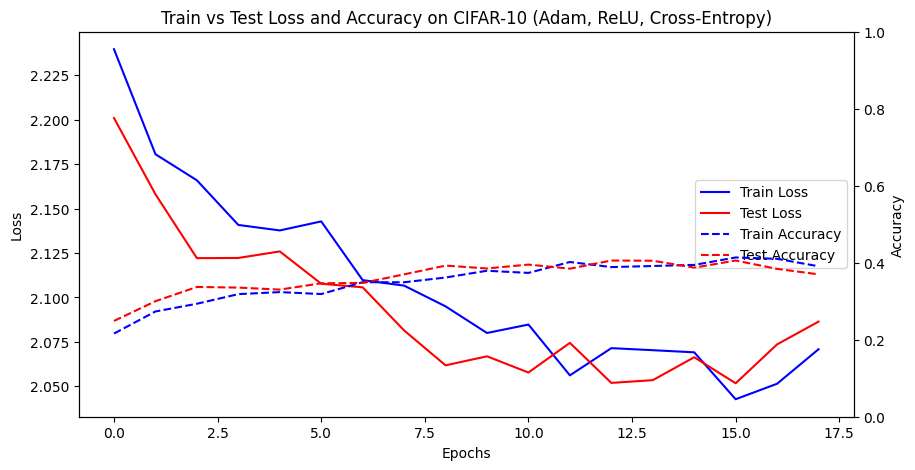

Experiment 4:

Reverted back to experiment 1's case with a batch size of 256 instead of 128. Stripped the CNN back down to the original 3 convolutions. Planning on increasing the training batch size.

--- Experiment Summary ---

Training Loss: 1.9601, Training Accuracy: 0.4959

Validation Loss: 1.9792, Validation Accuracy: 0.4791

Total Training Runtime: 857.37 seconds

Best Validation Accuracy: 0.4791 at Epoch 19 of 20

Final Test Loss: 1.9912, Final Test Accuracy: 0.4670

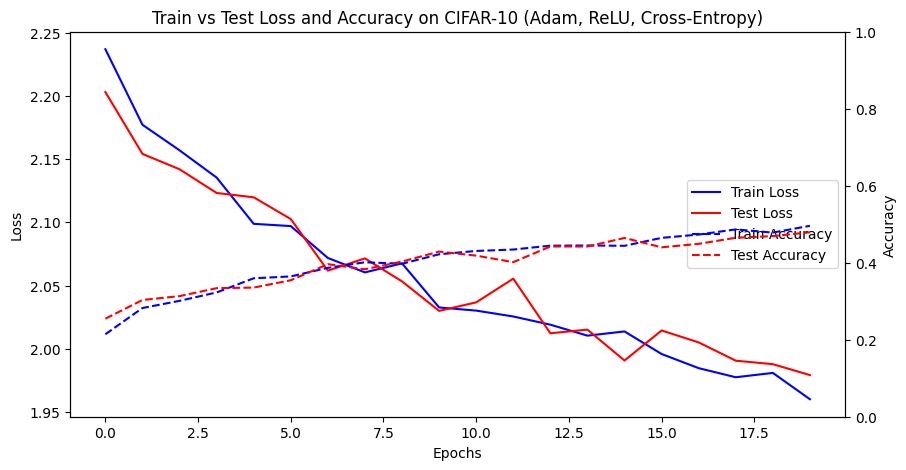


Experiment 5:

Increased the batch size up to 528 since I saw a benefit after I increased it last time.

--- Experiment Summary ---

Training Loss: 1.8638, Training Accuracy: 0.5974

Validation Loss: 1.9203, Validation Accuracy: 0.5415

Total Training Runtime: 870.92 seconds

Best Validation Accuracy: 0.5415 at Epoch 19 of 20

Final Test Loss: 1.9125, Final Test Accuracy: 0.5446

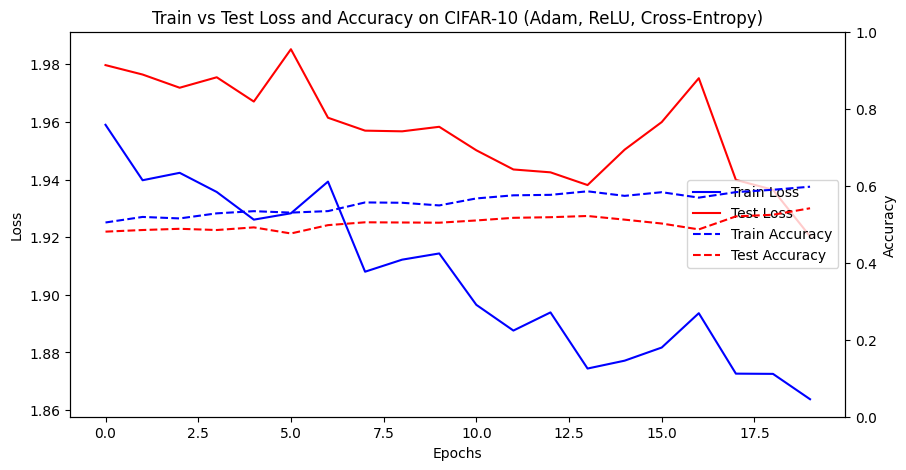

Experiment 6:

Increasing the training batch size further to 1024 and deepened the first CNN output channel by double (32 -> 64). Ran into an overflow error so I had to undo the CNN change and keep the batch size change. Trying to get better understanding of finer details in the images since the resolution in Imagenette is higher than CIFAR10. Accuracy increased by about 1%, increasing batch size further likely wont provide significant improvements.


--- Experiment Summary ---

Training Loss: 1.7939, Training Accuracy: 0.6631

Validation Loss: 1.9040, Validation Accuracy: 0.5557

Total Training Runtime: 863.74 seconds

Best Validation Accuracy: 0.5589 at Epoch 16 of 20

Final Test Loss: 1.8985, Final Test Accuracy: 0.5583

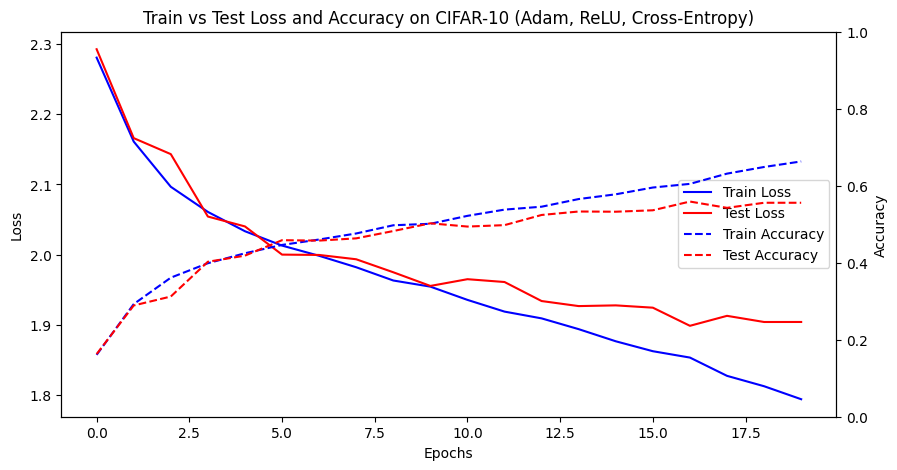

Experiment 7:

Added data augmentation and saw a drastric fall in accuracy. I did horizontal flips and color jitter.

I decided to remove color augmentation and try geometric ones instead: keeping the flip, adding rotation, and adding cropping.

--- Experiment Summary ---

Training Loss: 2.1891, Training Accuracy: 0.2714

Validation Loss: 2.1759, Validation Accuracy: 0.2853

Total Training Runtime: 1191.87 seconds

Best Validation Accuracy: 0.3011 at Epoch 8 of 13

Final Test Loss: 2.1790, Final Test Accuracy: 0.2807

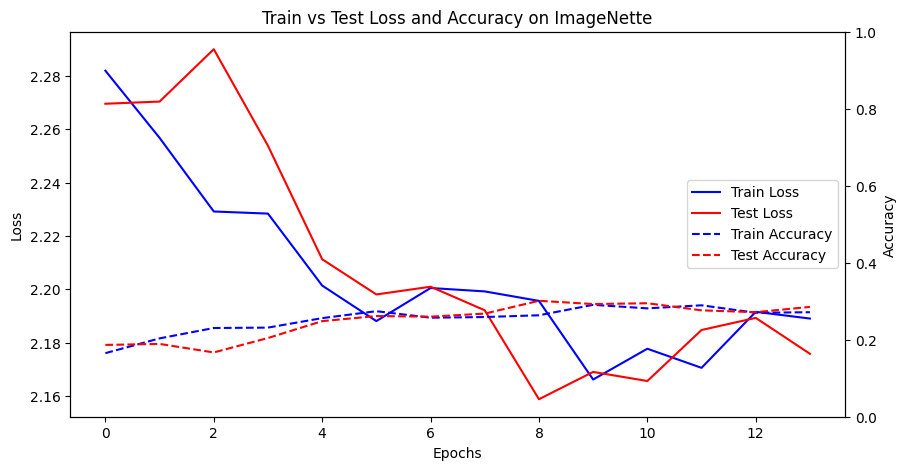

Experiment 8:

The geometric data augmentation had pretty much no benefit compared to the previous experiment and the results were still poor. I tinkered with a "warm-up" dataset to pretrain the model before the data augmentation but did not see much progress with the results so I decided to remove the data augmentation and revert back to the conditions of experiment 6.


--- Experiment Summary ---

Training Loss: 2.1631, Training Accuracy: 0.2996

Validation Loss: 2.1544, Validation Accuracy: 0.3074

Total Training Runtime: 913.17 seconds

Best Validation Accuracy: 0.3249 at Epoch 13 of 18

Final Test Loss: 2.1635, Final Test Accuracy: 0.2971

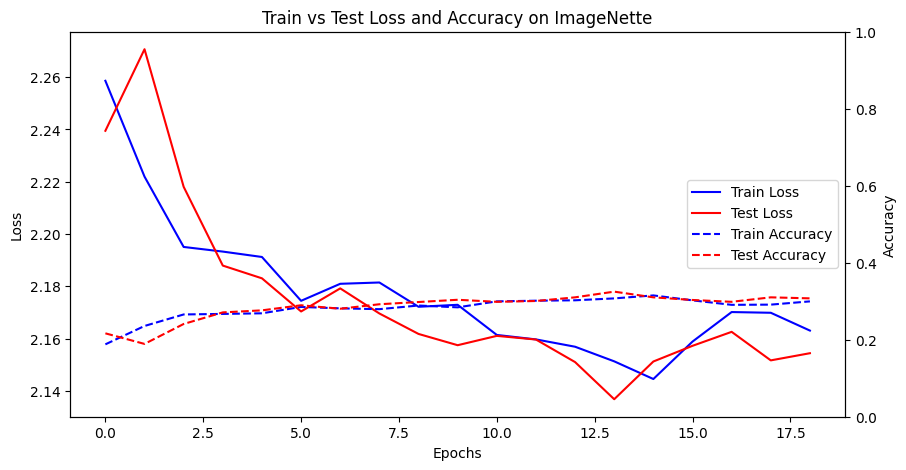

Experiment 9:

I reverted the code back to experiment 6 and retrained/tested and got poorer results. I was not able to figure out what shifted or change, I went through all the variables. Regardless, the results were still better than exp 7 and 8.

I am going to run an extra experiment because of this.

--- Experiment Summary ---

Training Loss: 1.9911, Training Accuracy: 0.4684

Validation Loss: 2.0214, Validation Accuracy: 0.4385

Total Training Runtime: 866.87 seconds

Best Validation Accuracy: 0.4385 at Epoch 19 of 20

Final Test Loss: 2.0323, Final Test Accuracy: 0.4253

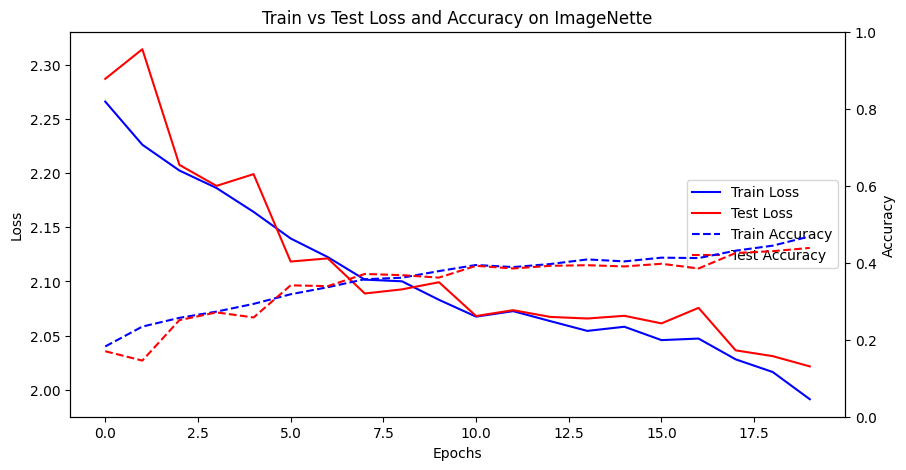

Experiment 10:

I initially bumped up the LR but saw the results were not changing, so I reverted the LR and got rid of the L2 regularization and finally saw significant improvement. Test Accuracy jumped back to 53%, planning on decreasing the threshhold for the LR scheduler to 2 epochs (from 3) to drop the LR faster as the accuracy plateus. I also decided to make the dropout more aggressive (0.25 -> 0.4)

--- Experiment Summary ---

Training Loss: 1.8001, Training Accuracy: 0.6594

Validation Loss: 1.9093, Validation Accuracy: 0.5483

Total Training Runtime: 867.33 seconds

Best Validation Accuracy: 0.5626 at Epoch 18 of 20

Final Test Loss: 1.9241, Final Test Accuracy: 0.5303

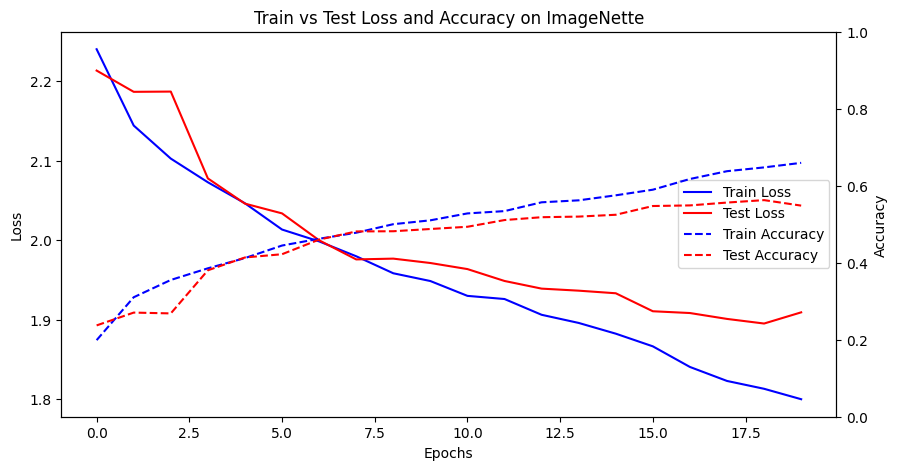

Experiment 11:

I decreased the LR threshold to 2 and increased the dropout but saw no overfitting. To allow for some margin, I reduced the dropout again for the next experiment.

--- Experiment Summary ---

Training Loss: 1.9147, Training Accuracy: 0.5429

Validation Loss: 1.9137, Validation Accuracy: 0.5452

Total Training Runtime: 866.43 seconds

Best Validation Accuracy: 0.5452 at Epoch 19 of 20

Final Test Loss: 1.9191, Final Test Accuracy: 0.5367

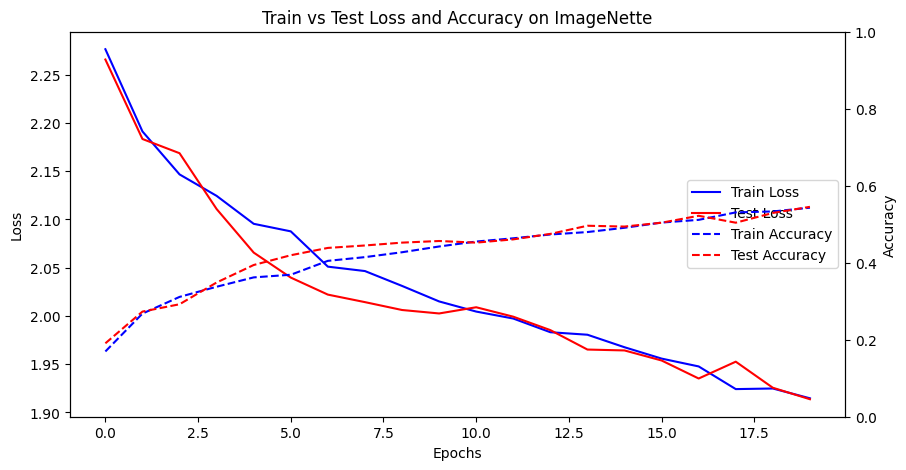

Experiment 12:

Returned the dropout to 0.2 to allow for some overfitting. As a result, there was more divergence between train and test. I also allowed for the training to go for 30 epochs instead of 20 and saw a mild improvement in accuracy.

Overall, best results occured in experiment 6 and a close second with experiment 12.

--- Experiment Summary ---

Training Loss: 1.7721, Training Accuracy: 0.6869

Validation Loss: 1.8946, Validation Accuracy: 0.5589

Total Training Runtime: 1293.27 seconds

Best Validation Accuracy: 0.5589 at Epoch 29 of 30

Final Test Loss: 1.9100, Final Test Accuracy: 0.5467

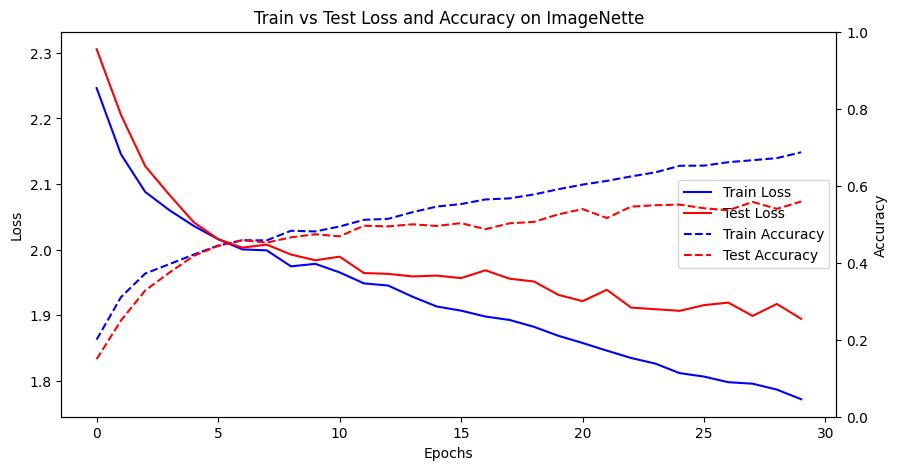

4) Derive the formula for backpropagating gradients through a convolutional layer.

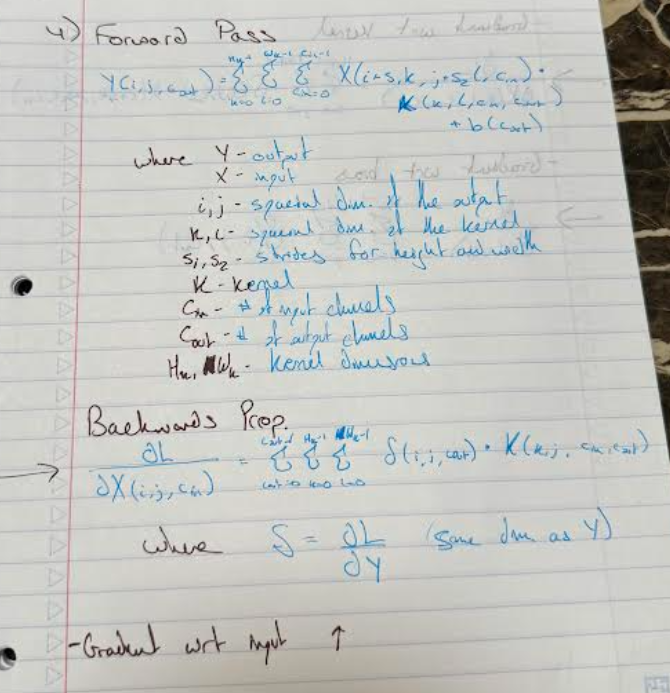

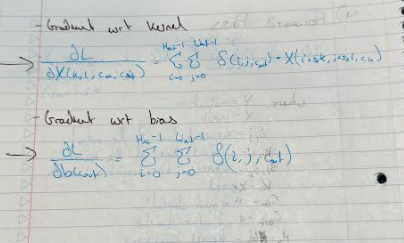

**5)** Give a detailed accounting of the number of parameters in your best model from Problem 3. (Hint. PyTorch will give you a parameter count--your job is to write up how it's computed based on your architecture.)

**Model Architecture**

Given:

  Image dimensions: 224 x 224 x 3

  Number of classes: 10

  Dropout layers do not have parameters, so we will skip them in the count.

1. First Convolutional Layer (Conv2d)

  Input: 224 x 224 x 3

  Out channels: 32

  Kernel size: 5 x 5

  Padding: 'same', so the output dimension is still 224 x 224

  Parameters = (5 x 5 x 3) x 32 + 32 = 2,432
(where 32 is the number of output channels, and each channel has a bias term)

2. Batch Normalization (BatchNorm2d) after Conv2d

  Out channels: 32

  Parameters = 32 x 2 = 64
(Two parameters for each feature map: one for scaling and one for shifting.)

3. Second Convolutional Layer (Conv2d)
  
  Input: 112 x 112 x 32
  
  Out channels: 64
  
  Kernel size: 5 x 5
  
  Padding: 'same', so the output dimension is 112 x 112
  
  Parameters = (5 x 5 x 32) x 64 + 64 = 51,264

4. Batch Normalization (BatchNorm2d) after Conv2d

  Out channels: 64

  Parameters = 64 x 2 = 128

5. Third Convolutional Layer (Conv2d)
  Input: 56 x 56 x 64
  
  Out channels: 128
  
  Kernel size: 5 x 5
  
  Padding: 'same', so the output dimension is 56 x 56
  
  Parameters = (5 x 5 x 64) x 128 + 128 = 204,928

6. Batch Normalization (BatchNorm2d) after Conv2d

  Out channels: 128

  Parameters = 128 x 2 = 256

7. Flatten Layer

  Input: 56 x 56 x 128

  Output (Flattened): 401,408 features

8. First Fully Connected Layer (Linear)

  Input features: 401,408

  Output features: 150

  Parameters = 401,408 x 150 + 150 = 60,211,350

9. Second Fully Connected Layer (Linear)
  
  Input features: 150

  Output features: 10
  
  Parameters = 150 x 10 + 10 = 1,510
  
  Total Parameters

**Adding up all the parameters calculated from each layer:**

2,432 + 64 + 51,264 + 128 + 204,928 + 256 + 60,211,350 + 1,510 = **60,471,932**